# 01. Map polynya events with University Bremen ASI Sea Ice Concentrations

Data source:
https://seaice.uni-bremen.de/sea-ice-concentration/amsre-amsr2/

**This version of the map is edited by Noel Wang, based on the original code by Mackenzie Jewell**

This version is in the fork.

Note: the date ranges of this file are from 

June 6 2002 to 7 29 2002 <br>
8-08-2002- Oct 4 2011 <br>
July 7 2012 to june 13 2024 <br>

Note: to specify the version of Python used by the AK_polynya environment, edit the environment.yml file python ==version

## Import packages

In [8]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider #import packages for the slider
import matplotlib.animation as animation #imported for animation
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *

%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

#import shapely
import shapely

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# This was to help me determine the correct date range for pulling the data
# list = []
# daterange = pd.date_range(datetime(2024, 1, 1), datetime(2024, 1, 5))
# for date in daterange:
#     if date > datetime(2024, 1, 2) and date < datetime(2024, 1, 4):
#         continue
#     else:
#         print(date)

## Make map

82.89619


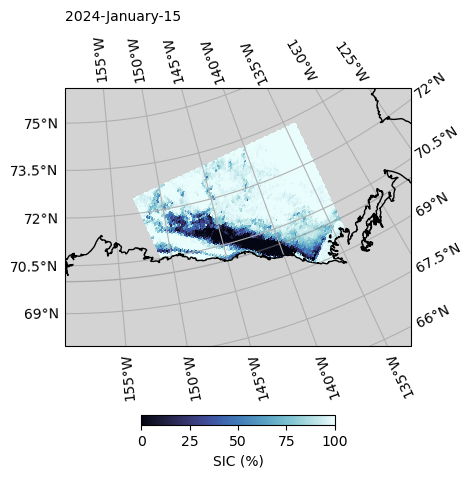

In [3]:
#making the date list
#============================
date_list = pd.date_range(datetime(2024, 1, 15), datetime(2024, 1, 15)) #make this a date list

#============================

for date in date_list:
    if date > datetime(2011, 10, 4) and date < datetime(2012, 7, 2):
        continue
        
    else:
        # read daily sic data from computer files into dictionary
        data = grab_ASI_SIC(date=date.to_pydatetime(), 
                        main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
                        coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                        hemisphere='n', resolution='6250', version='v5.4', 
                        return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                        include_units=False, annual_folders=False, return_dict = True, quiet=True)


        # create figure
        #--------------
        # create map figure in north polar stereographic projection
        map_projection = ccrs.NorthPolarStereo(central_longitude=200) #rotation of the map
        fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection=map_projection))

        # background color
        ax.patch.set_facecolor('lightgray')

        # set map extent [lon1, lon2, lat1, lat2]
        ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

        # add coastlines
        ax.coastlines(zorder=100)

        # lat / lon lines
        add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)
        ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)


        # plot 2d sic data 
        # icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
        #                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])
        
        #datarange
        d1 = (850, 950) #along y
        d2 = (200, 325) #along x


        # # plot 2d sic data (all)
        # icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
        #                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

        # plot 2d sic data (limited)
        icec = ax.pcolormesh(data['xx'][d1[0]:d1[1], d2[0]:d2[1]], data['yy'][d1[0]:d1[1], d2[0]:d2[1]], data['sic'][d1[0]:d1[1], d2[0]:d2[1]], 
                            cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

        #visualize the data points        
        # sp =10
        # ax.scatter(data['xx'][::sp, ::sp], data['yy'][::sp, ::sp], transform=data['proj'])

        #add colorbar
        plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.5, pad=0.18)

        # label date
        ax.text(0, 1.25, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)

        #plt.show()

        # #save figure, if desired
        # save_path = f'/Users/reu/Desktop/Maps/allJan/Jan2024/cropped_map_{date.strftime("%Y-%m-%d")}.png'
        # fig.savefig(save_path, dpi=300, bbox_inches = 'tight')
        # maps_list.append(save_path)

        #plt.clf()

    datarange = data['sic'][d1[0]:d1[1], d2[0]:d2[1]]
    print(np.nanmean(datarange))


### Time Series Plots

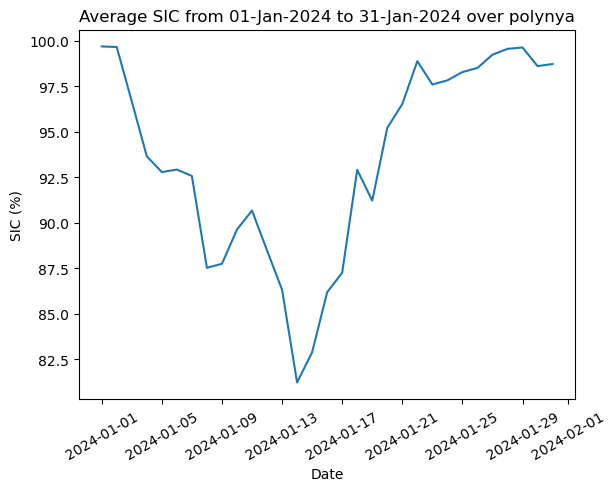

In [6]:
#making the date list
#============================
date_list = pd.date_range(datetime(2024, 1, 1), datetime(2024, 1, 31)) #make this a date list

#============================

#datarange
d1 = (850, 950) #along y
d2 = (200, 325) #along x

#list of SIC Concentrations
SIC_list = []

for date in date_list:
    if date > datetime(2011, 10, 4) and date < datetime(2012, 7, 2):
        continue      
    else:
        # read daily sic data from computer files into dictionary
        data = grab_ASI_SIC(date=date.to_pydatetime(), 
            main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
            coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
            hemisphere='n', resolution='6250', version='v5.4', 
            return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
            include_units=False, annual_folders=False, return_dict = True, quiet=True)
        
        datarange = data['sic'][d1[0]:d1[1], d2[0]:d2[1]]
        average_SIC = (np.nanmean(datarange))
        SIC_list.append(average_SIC)

# Creating the plot
x = date_list
y = SIC_list
plt.plot(x,y)

# Adding a title
plt.title(f'Average SIC from {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")} over polynya')

# Adding and customizing axis labels
plt.xlabel('Date')
plt.ylabel('SIC (%)')
plt.xticks(rotation=30)
# plt.xticks(np.arange(date_list[0], date_list[-1], 1))

plt.show()



In [31]:
datarange = data['sic'][d1[0]:d1[1], d2[0]:d2[1]]
np.nanmean(datarange)

96.07265

#### Useful lines of code for seeing information about the dataset

In [41]:
#a useful line for seeing information about a dataset. This works for 'xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds' 
#data["ds"]
#data['proj']

# data['ds'].x.shape

#data['yy'][d1[0]:d1[1], :]

In [37]:
#example of a graph of all of the data. Not quite sure why it's in Vikings colors though
#plt.pcolormesh(data['xx'], data['yy'], data['sic'])

#### Creating a cropped map in the original coordinate system

<class 'cartopy.crs.NorthPolarStereo'>


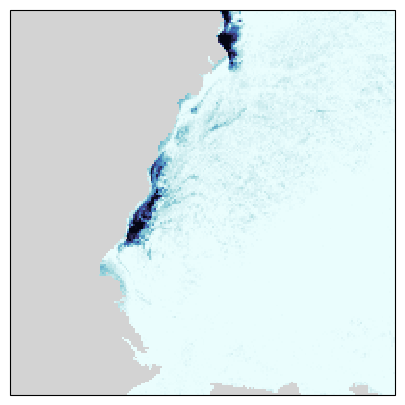

In [51]:
# create figure
#--------------
# create map figure in north polar stereographic projection
map_projection = data['proj']
# map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection=map_projection))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
# ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

#datarange
d1 = (800, 1000) #along y
d2 = (200, 400)

# plot 2d sic data 
icec = ax.pcolormesh(data['xx'][d1[0]:d1[1], d2[0]:d2[1]], data['yy'][d1[0]:d1[1], d2[0]:d2[1]], data['sic'][d1[0]:d1[1], d2[0]:d2[1]], 
                    cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

#plotting a grid of points
# sp = 50
# ax.scatter(data['xx'][::sp, ::sp], data['yy'][::sp, ::sp], transform=data['proj'])
#transform tells function original >> map_projection

#highlighting a subset of data 
#ax.scatter(data['xx'][d1[0]:d1[1], d2[0]:d2[1]][::sp, ::sp], data['yy'][d1[0]:d1[1], d2[0]:d2[1]][::sp, ::sp], transform=data['proj'], c='orange')

#showing a subset of the data
#data['xx']
#data["ds"].x.values

print(type(data["proj"]))

## Make images into a GIF

In [40]:
#I ended up using MacKenzie's code for this

# import imageio
# images = []
# for filename in :
#     images.append(imageio.imread(save_path))
# imageio.mimsave('/path/to/movie.gif', images)

## Plot the map with the slider

In [ ]:
# #plot the map
# plt.show()

        # #make a vertical slider for the date
        # fig.subplots_adjust(left=0.25) #move the plot over to make room for the slider
        # axdate = fig.add_axes([0.1, 0.25, 0.0225, 0.63]) #make a box to put the slider in
        # time_slider = Slider(
        #     ax=axdate,
        #     label="Date",
        #     valmin=0,
        #     valmax=100
        # )